# Customer Query Classification
### Hoori Javadnia & Fatemeh Khosravi

In [1]:
#!pip install --upgrade emoji
#!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=5614fe176293f08405987f0c276b4d77203c41e1bf7bba4e33b950cec1bdcf3b
  Stored in directory: /Users/fatemehkhosravi/Library/Caches/pip/wheels/8d/f5/02/63dc849dcc2c6d417626fd8440f2fc9da91c2f12afbe65c790
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.2.0
    Uninstalling emoji-2.2.0:
      Successfully uninstalled emoji-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import requests
import time
import random
from collections import OrderedDict
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
import random
py.init_notebook_mode(connected=True)
from nltk.stem import WordNetLemmatizer
from random import randint
#from textblob import TextBlob
from time import sleep
color = sns.color_palette()
%matplotlib inline
from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
import plotly.io as pio
import emoji
from nltk.tokenize import word_tokenize
import re
re.compile('<title>(.*)</title>')
import nltk
import os
import re
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
sw = stopwords.words("english")


### Read the Data

In [126]:
#Read the data

customer_queries = pd.read_csv('/Users/fatemehkhosravi/Desktop/cus_q_dataset_final.csv')

### Dimension 

The dataset consists of 40,267 samples (queries) with response variable in the 'Class' Column.

In [127]:
#Dimension of the data set

print(customer_queries.shape)

#10 samples from data set

customer_queries.sample(10)

(40267, 2)


,Query,Class
6044,\r\n\r\nIs there an easy way to return my purc...,Returns
307,\r\n\r\nDo you need help understanding the ite...,Billing
10151,\r\n\r\nWhat sizes does the t-shirt come in?,Product Inquiry
3960,\r\n\r\nDo these shoes come in different width...,Product Inquiry
31171,"\r\n\r\nDo I need to make a payment today, or ...",Billing
33012,\r\n\r\nI'm concerned about the ease of assemb...,Product Inquiry
16547,\r\n\r\nDo you accept American Express cards a...,Billing
37678,\r\n\r\nI was curious if this product is inter...,Product Inquiry
18839,\r\nenter\r\n\r\nHas my item been processed ac...,Returns
15692,\r\n\r\nCan I get help connecting my printer t...,Tech. Support


### Check the Balance

Data set has 4 different classes: ‘Billing', 'Product Inquiry, 'Return' and 'Tech. Support’. According to the barplot, the dataset is balanced.

In [128]:
# Check different classes of the response variable 

customer_queries['Class'].value_counts()

Billing            10069
Product Inquiry    10067
Returns            10066
Tech. Support      10065
Name: Class, dtype: int64

<AxesSubplot:title={'center':"' Barplot of the Class Values'"}, xlabel='Class'>

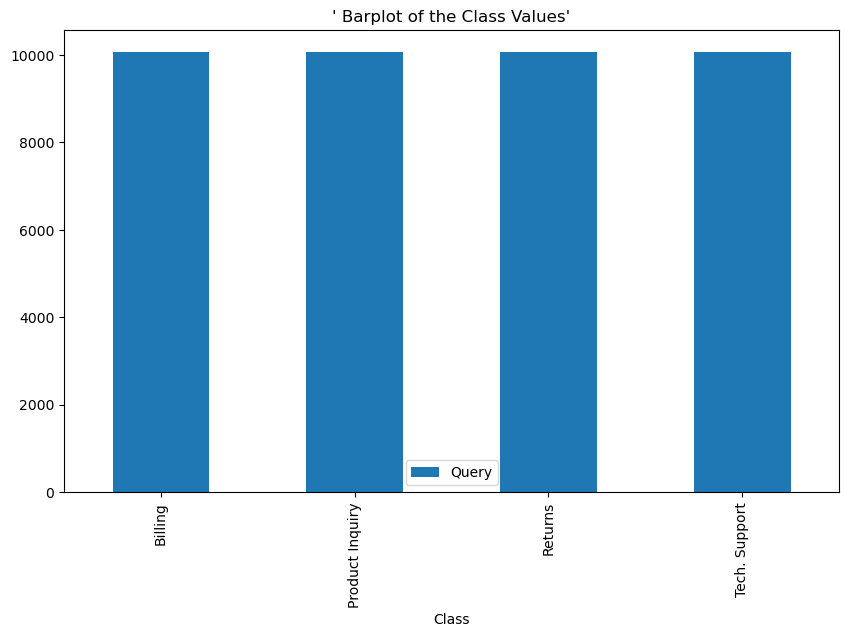

In [129]:
# Barplot of the 'Class' values

customer_queries.groupby('Class').agg({'Query': 'count'}).plot.bar(figsize=(10,6), 
                                    title="' Barplot of the Class Values'")

In [130]:
# Some punctuation variations

punctuation = set(punctuation) 


# Stopwords

sw = stopwords.words("english")


# useful regex

whitespace_pattern = re.compile(r"\s+")


#Descriptive function

def descriptive_stats(tokens, num_tokens = 10, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    
    if verbose :        
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the data.")
    
        counts = Counter(tokens)

        if num_tokens > 0 :
            print("The top ten most common tokens are:")
            top_tokens=counts.most_common(num_tokens)
            top_token_df = pd.DataFrame(top_tokens, columns = ["Token", "Frequency"])
            print(top_token_df)
        
    return([len(tokens),
           len(set(tokens)),
           len("".join(tokens)),
           len(set(tokens))/len(tokens)])

        



# Remove stop words

def remove_stop(tokens) : 
    return([t for t in tokens if t.lower() not in sw])

# Remove punctuation

def remove_punctuation(text, punct_set=punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))

#Remove white space

def remove_whitespace(text):
    text = whitespace_pattern.sub(r" ", text)
    return text

# Tokenization

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([t for t in whitespace_pattern.split(text) if t])

# pipeline function

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


In [131]:
# Apply processing pipeline

prep_pipeline = [str.lower, remove_punctuation,remove_whitespace, tokenize, remove_stop]

# Tokenization on 'Query' column

customer_queries["tokens"] = customer_queries["Query"].apply(prepare, pipeline = prep_pipeline)

# Count number of tokens in each row

customer_queries["num_tokens"] = customer_queries["tokens"].map(len) 

customer_queries.sample(11)


,Query,Class,tokens,num_tokens
31061,\r\n\r\nWhat plug-in type do I need for a podc...,Tech. Support,"[plugin, type, need, podcast, inithibition, pr...",7
25570,\r\n\r\nIs this product good for taking macros...,Product Inquiry,"[product, good, taking, macros, images, withou...",9
4798,\r\n\r\nWhat type of fabric is this leisurewea...,Product Inquiry,"[type, fabric, leisurewear, blazer, made, mach...",7
9520,\r\n\r\nWhat is the total taxable amount inclu...,Billing,"[total, taxable, amount, included, recent, inv...",6
34052,\r\n\r\nHow can I return this item and get a f...,Returns,"[return, item, get, full, refund]",5
20350,\r\n\r\nIs my credit card billing statement se...,Billing,"[credit, card, billing, statement, set, email,...",13
38763,\r\n\r\nDid you send the incorrect item? I rec...,Returns,"[send, incorrect, item, recently, received, ch...",15
37199,\r\n\r\nIs my credit card payment merchant saf...,Billing,"[credit, card, payment, merchant, safe, submis...",6
39583,\r\n\r\nMy account won't let me pay online - w...,Tech. Support,"[account, wont, let, pay, online]",5
32803,\r\nQ: Can I return a packaged double puppet d...,Product Inquiry,"[q, return, packaged, double, puppet, dolls, s...",9


### Descriptive Statistics

Descriptive statistics output is displayed in the code snippet below.
'return', 'product', 'item', 'purchased' and 'payment' are the top ten most common tokens in this dataset.

In [132]:
# We need to transform the Query to lists of tokens for descriptive statistics

tokens_list = customer_queries['tokens'].to_list()

# convert nested list to a flat list

tokens_list  = [item for sublist in tokens_list  for item in sublist]

In [133]:
print("Descriptive Stats:\n")

print(descriptive_stats(tokens_list ))


Descriptive Stats:

There are 364359 tokens in the data.
There are 20993 unique tokens in the data.
There are 2295191 characters in the data.
The lexical diversity is 0.058 in the data.
The top ten most common tokens are:
       Token  Frequency
0     return       8343
1    product       6413
2       item       5398
3  purchased       4106
4    payment       3736
5   recently       3689
6      order       3281
7     please       3227
8         im       3200
9       need       3171
[364359, 20993, 2295191, 0.057616252103008296]


### Query Lengths

Here we can see the distribution histogram of lengths of queries ( number of tokens ) based on its class. According to this plot ‘Billing’ and ‘Returns’ categories have the highest number of tokens in the query. (35 and 38 tokens. The average number of tokens for all classes is about 10 tokens.  

Class
Billing            AxesSubplot(0.125,0.11;0.775x0.77)
Product Inquiry    AxesSubplot(0.125,0.11;0.775x0.77)
Returns            AxesSubplot(0.125,0.11;0.775x0.77)
Tech. Support      AxesSubplot(0.125,0.11;0.775x0.77)
Name: num_tokens, dtype: object

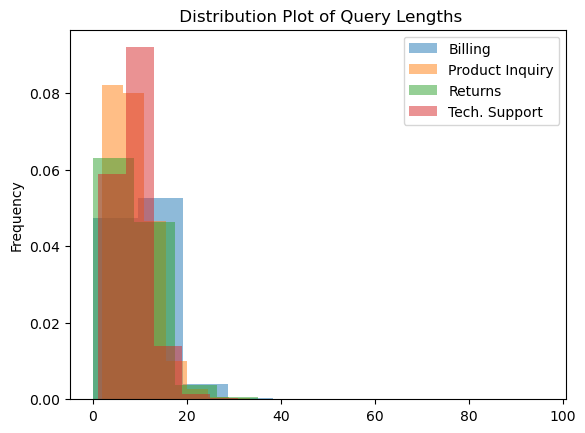

In [134]:
customer_queries.groupby('Class')['num_tokens'].plot(kind="hist",density=True,alpha=0.5,
                         legend=True, title= " Distribution Plot of Query Lengths")

### Descriptive Statistics of Each Class

* Lexical diversity for 'Product Inquiry' class is about 0.127 and for 'Billing' and 'Tech. Support' classes is about 0.078. The lowest lexical diversity belongs to the 'Return' class with 0.065. Higher value means that the queries contain many different word types while lower value of lexical diversity refers to the repeated words or phrases. 

* By removing punctuation in the way we did, a number of pairs of stopwords (e.g., "I am" and "is not") show up in the top 10 tokens.

In [153]:
# Billing

billing_query= customer_queries.loc[customer_queries['Class']== 'Billing'].tokens.to_list()
billing_query = [item for sublist in billing_query for item in sublist]


#Product Inquiry

product_query = customer_queries.loc[customer_queries['Class']== 'Product Inquiry'].tokens.to_list()
product_query = [item for sublist in product_query for item in sublist]


# Returns

return_query= customer_queries.loc[customer_queries['Class']== 'Returns'].tokens.to_list()
return_query= [item for sublist in return_query for item in sublist]


#Tech.Support

tech_query = customer_queries.loc[customer_queries['Class']== 'Tech. Support'].tokens.to_list()
tech_query = [item for sublist in tech_query for item in sublist]

In [158]:
# Descriptive Statistics of Billing Class

print("Descriptive Statistics of Billing Class:\n")

print(descriptive_stats(billing_query, num_tokens=10 ))


Descriptive Statistics of Billing Class:

There are 108398 tokens in the data.
There are 8470 unique tokens in the data.
There are 683268 characters in the data.
The lexical diversity is 0.078 in the data.
The top ten most common tokens are:
       Token  Frequency
0    payment       3642
1     please       2288
2    billing       2269
3       bill       1710
4      order       1640
5    invoice       1568
6    account       1225
7   purchase       1117
8       card       1090
9  statement       1078
[108398, 8470, 683268, 0.07813797302533257]


In [159]:
# Descriptive Statistics of Product Inquiry Class

print("Descriptive Statistics of Product Inquiry Class:\n")

print(descriptive_stats(product_query, num_tokens=10 ))


Descriptive Statistics of Product Inquiry Class:

There are 86000 tokens in the data.
There are 10881 unique tokens in the data.
There are 552211 characters in the data.
The lexical diversity is 0.127 in the data.
The top ten most common tokens are:
       Token  Frequency
0    product       4381
1         im       1328
2  available        731
3       come        692
4       size        679
5        use        644
6   products        595
7    looking        587
8   warranty        571
9       type        567
[86000, 10881, 552211, 0.1265232558139535]


In [160]:
# Descriptive Statistics of Return Class

print("Descriptive Statistics of Return Class:\n")

print(descriptive_stats(return_query, num_tokens=10 ))


Descriptive Statistics of Return Class:

There are 88127 tokens in the data.
There are 5765 unique tokens in the data.
There are 556304 characters in the data.
The lexical diversity is 0.065 in the data.
The top ten most common tokens are:
       Token  Frequency
0     return       8042
1       item       4785
2  purchased       3227
3   recently       2291
4     refund       1961
5    product       1809
6    process       1729
7     policy       1563
8  returning       1336
9       need       1310
[88127, 5765, 556304, 0.06541695507619685]


In [161]:
# Descriptive Statistics of Tech. Support Class

print("Descriptive Statistics of Tech. Support Class:\n")

print(descriptive_stats(tech_query, num_tokens=10 ))

Descriptive Statistics of Tech. Support Class:

There are 81834 tokens in the data.
There are 6363 unique tokens in the data.
There are 503408 characters in the data.
The lexical diversity is 0.078 in the data.
The top ten most common tokens are:
      Token  Frequency
0    laptop       2343
1  computer       2168
2      wont       1769
3   printer       1443
4     issue       1145
5      wifi       1114
6      isnt       1091
7       fix       1056
8      turn       1030
9        im        992
[81834, 6363, 503408, 0.07775496737297456]
